In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/mva/dlir/src


In [3]:
import torch
torch.cuda.is_available()

True

# Imports

In [4]:
from utils import *
from params import *

In [5]:
from metric import *

In [6]:
from training import *
from dcgan import *
from data import *

In [7]:
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

# Initialization

In [8]:
begin = time.time()
seed_everything(seed)

## Load Data

In [9]:
print('Number of dog images :', len(IMAGES))

Number of dog images : 20579


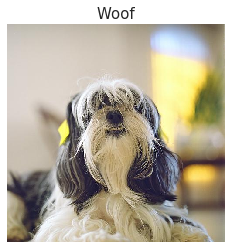

In [10]:
img = Image.open(IMAGES[0])
plt.imshow(img)
plt.title('Woof', size=15)
plt.axis(False)
plt.show()

## Seeding

# Dataset

In [11]:
%%time
dataset = DogDataset(DATA_PATH, base_transforms, additional_transforms)

CPU times: user 25.3 s, sys: 1.59 s, total: 26.8 s
Wall time: 47.6 s


In [12]:
nb_classes = len(dataset.classes)
print(f'Number of dog breeds : {nb_classes}')

Number of dog breeds : 120


In [13]:
nb_dogs = len(dataset)
print(f'Number of dog: {nb_dogs}')

Number of dog: 22125


In [14]:
# n = 5
# plt.figure(figsize=(15, 3))
# for idx, i in enumerate(np.random.choice(len(dataset), n)):
#     plt.subplot(1, n, idx + 1)
#     img, breed = dataset[i]
#     plt.imshow(img)
#     plt.axis(False)
    
#     plt.title(dataset.classes[breed])
# plt.show()

## Fit

In [15]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.nn import Parameter
from torch.autograd import Variable
from torch.optim.lr_scheduler import *

In [16]:
def fit(discriminator, generator, dataset, latent_dim=128, epochs=100, batch_size=32, 
        lr_d=1e-3, lr_g=1e-3, scheduler=False, label_smoothing=False,
        class_loss_weight=0., use_ft_matching=False,
        seed=2019, verbose=1, verbose_mifid=100):
    
    seed_everything(seed)
    fixed_noise = torch.FloatTensor(5, latent_dim, 1, 1).normal_(0, 1).cuda()
    fixed_classes = torch.from_numpy(np.random.randint(0, nb_classes, size=5)).long().cuda()
    infos = {"discriminator_loss": [], "generator_loss": [], 'generator_lr': [], 'discriminator_lr': []}
    
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    
    scheduler_d = CosineAnnealingLR(optimizer_d, T_max=epochs, eta_min=1e-5)
    scheduler_g = CosineAnnealingLR(optimizer_g, T_max=epochs, eta_min=1e-5)
    
    loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
    loss_classes_fn = nn.CrossEntropyLoss(reduction='sum')
    loss_ft_matching = nn.MSELoss(reduction='sum')
    
    real_label = 0.9 if label_smoothing else 1.
    fake_label = 0.
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=True)

    for epoch in range(epochs):
        start_time = time.time()  
        d_loss = 0
        g_loss = 0
        
        if scheduler:
            scheduler_d.step()
            scheduler_g.step()
            lr_d = np.mean([param_group['lr'] for param_group in optimizer_d.param_groups])
            lr_g = np.mean([param_group['lr'] for param_group in optimizer_g.param_groups])
            
        for x, y in loader:
            t0 = time.time()

            ########   Update discriminator ########

            discriminator.zero_grad()
            batch_size = x.size(0)

            # Real images

            labels = torch.full((batch_size, 1), real_label).cuda()

            output, out_classes, _ = discriminator(x.cuda(), y.cuda())

            loss_real = loss_fn(output, labels)
            if class_loss_weight:
                loss_real += class_loss_weight * loss_classes_fn(out_classes, y.cuda())
            loss_real.backward()

            # Fake images

            noise = torch.cuda.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)
            fake_classes = torch.from_numpy(np.random.randint(0, nb_classes, size=batch_size)).long().cuda()
            fake = generator(noise, fake_classes)

            labels.fill_(fake_label)
            output, out_classes, _ = discriminator(fake.detach(), fake_classes)

            loss_fake = loss_fn(output, labels)
            if class_loss_weight:
                loss_fake += class_loss_weight * loss_classes_fn(out_classes, fake_classes)
                
            loss_fake.backward()
            optimizer_d.step()
            
            d_loss += (loss_real + loss_fake).item() / len(dataset)
            
            
            ########   Update Generator   ########
            
            generator.zero_grad()
            labels.fill_(real_label)
            
            noise = torch.cuda.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)
            fake_classes = torch.from_numpy(np.random.randint(0, nb_classes, size=batch_size)).long().cuda()
            
            output_fake, out_classes, features_fake = discriminator(fake, fake_classes)
            
            if use_ft_matching:
                _, _, features_real = discriminator(x.cuda(), y.cuda())
                loss_g = loss_ft_matching(torch.mean(features_real, 0), torch.mean(features_fake, 0))
            else:
                loss_g = loss_fn(output_fake, labels)
                
            if class_loss_weight:
                loss_g += class_loss_weight * loss_classes_fn(out_classes, fake_classes)
                
            loss_g.backward()
            
            g_loss += loss_g.item() / len(dataset)
            optimizer_g.step()   

        elapsed_time = time.time() - start_time
        
        infos['discriminator_loss'].append(d_loss)
        infos['generator_loss'].append(g_loss)
        infos['generator_lr'].append(lr_g)
        infos['discriminator_lr'].append(lr_d)
        
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            print(f'Epoch {epoch+1}/{epochs}     lr_g={lr_g:.1e}     lr_d={lr_d:.1e}', end='     ')
            print(f'disc_loss={d_loss:.3f}     gen_loss={g_loss:.3f}     t={elapsed_time:.0f}s')
            if (epoch + 1) % verbose_mifid == 0 and epoch > 150:
                score = tmp_eval(generator, n_images=10000, latent_dim=latent_dim, nb_classes=nb_classes)
                seed_everything(seed + epoch)
                print(f'\n -> FID at epoch {epoch+1} is {score:.3f} \n')
            elif (epoch + 1) % 10 == 0:
                generate(generator, noise=fixed_noise, classes=fixed_classes, n=5, n_plot=5, latent_dim=latent_dim)
                
    return infos

# Training

In [17]:
seed_everything(seed)

In [18]:
latent_dim = 100

use_bn = True

conditional = False

auxiliary_clf = False
class_loss_weight = 0

embed_dim = 8

In [19]:
n_gen = 128
n_dis = 128
nb_ft = 1

In [20]:
batch_size = 64
lr_g = 5e-4  # tweak !
lr_d = 5e-4  # tweak !

scheduler = False
epochs = 200

In [21]:
 #0.5
use_ft_matching = False
label_smoothing = False

In [22]:
discriminator = DCGanDiscriminator(
    n=n_gen, 
    nb_ft=nb_ft,
    nb_classes=nb_classes, 
    embedding_dim=embed_dim, 
    conditional=conditional,
    auxiliary_clf=auxiliary_clf,
    use_bn=use_bn,
).cuda()

generator = DCGanGenerator(
    n=n_dis, 
    latent_dim=latent_dim, 
    nb_classes=nb_classes, 
    embedding_dim=embed_dim,
    conditional=conditional,
    use_bn=use_bn,
).cuda()

discriminator.apply(weights_init)
generator.apply(weights_init)

print('Build DCGAN.')

Build DCGAN.


Epoch 1/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.490     gen_loss=7.369     t=43s
Epoch 2/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.172     gen_loss=3.074     t=43s
Epoch 3/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.147     gen_loss=3.183     t=43s
Epoch 4/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.127     gen_loss=2.867     t=43s
Epoch 5/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.164     gen_loss=2.510     t=43s
Epoch 6/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.175     gen_loss=2.403     t=44s
Epoch 7/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.156     gen_loss=2.421     t=44s
Epoch 8/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.189     gen_loss=2.151     t=44s
Epoch 9/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.224     gen_loss=1.960     t=44s
Epoch 10/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.234     gen_loss=1.820     t=44s


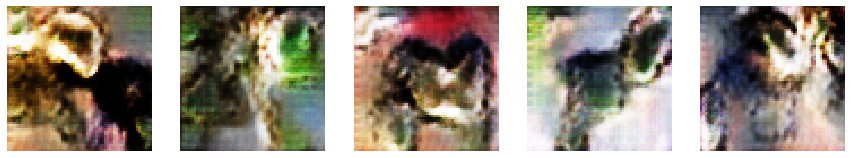

Epoch 11/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.188     gen_loss=1.946     t=44s
Epoch 12/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.155     gen_loss=2.082     t=44s
Epoch 13/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.172     gen_loss=2.075     t=44s
Epoch 14/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.183     gen_loss=2.082     t=44s
Epoch 15/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.213     gen_loss=1.992     t=44s
Epoch 16/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.193     gen_loss=1.973     t=44s
Epoch 17/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.208     gen_loss=1.899     t=44s
Epoch 18/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.202     gen_loss=1.894     t=44s
Epoch 19/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.172     gen_loss=1.919     t=44s
Epoch 20/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.180     gen_loss=1.891     t=44s


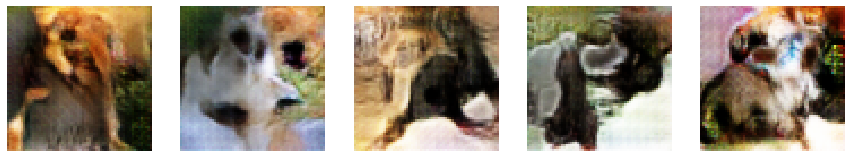

Epoch 21/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.155     gen_loss=1.900     t=44s
Epoch 22/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.157     gen_loss=1.921     t=44s
Epoch 23/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.139     gen_loss=1.911     t=44s
Epoch 24/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.120     gen_loss=1.955     t=44s
Epoch 25/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.098     gen_loss=2.006     t=44s
Epoch 26/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.070     gen_loss=2.054     t=44s
Epoch 27/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.056     gen_loss=2.137     t=44s
Epoch 28/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=1.043     gen_loss=2.141     t=44s
Epoch 29/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.967     gen_loss=2.272     t=44s
Epoch 30/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.936     gen_loss=2.374     t=44s


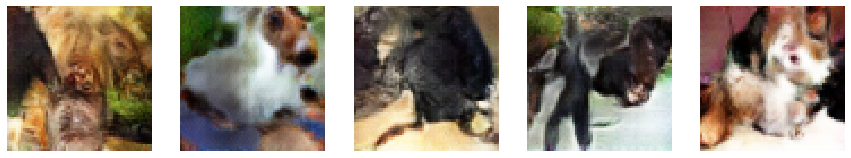

Epoch 31/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.922     gen_loss=2.451     t=44s
Epoch 32/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.901     gen_loss=2.495     t=44s
Epoch 33/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.907     gen_loss=2.560     t=44s
Epoch 34/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.834     gen_loss=2.674     t=44s
Epoch 35/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.933     gen_loss=2.705     t=44s
Epoch 36/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.804     gen_loss=2.610     t=44s
Epoch 37/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.805     gen_loss=2.758     t=44s
Epoch 38/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.917     gen_loss=2.817     t=44s
Epoch 39/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.680     gen_loss=2.842     t=44s
Epoch 40/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.706     gen_loss=3.051     t=44s


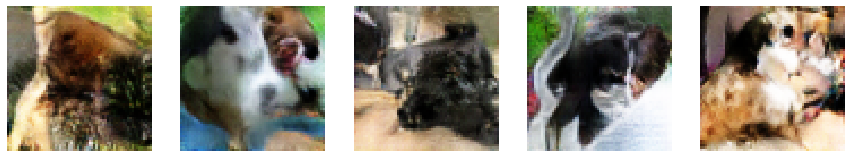

Epoch 41/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.737     gen_loss=3.166     t=44s
Epoch 42/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.771     gen_loss=3.106     t=44s
Epoch 43/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.671     gen_loss=3.109     t=45s
Epoch 44/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.597     gen_loss=3.327     t=44s
Epoch 45/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.727     gen_loss=3.512     t=44s
Epoch 46/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.760     gen_loss=2.931     t=44s
Epoch 47/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.562     gen_loss=3.433     t=44s
Epoch 48/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.510     gen_loss=3.647     t=44s
Epoch 49/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.701     gen_loss=3.580     t=44s
Epoch 50/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.611     gen_loss=3.503     t=44s


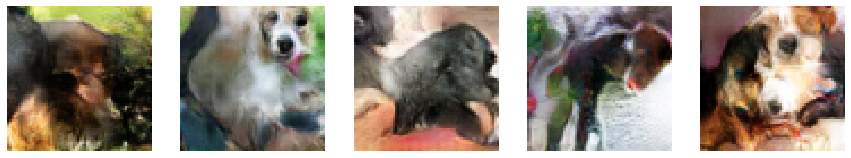

Epoch 51/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.637     gen_loss=3.701     t=44s
Epoch 52/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.435     gen_loss=3.752     t=44s
Epoch 53/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.492     gen_loss=4.000     t=44s
Epoch 54/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.630     gen_loss=3.811     t=44s
Epoch 55/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.486     gen_loss=3.918     t=44s
Epoch 56/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.743     gen_loss=3.762     t=44s
Epoch 57/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.486     gen_loss=3.795     t=44s
Epoch 58/200     lr_g=5.0e-04     lr_d=5.0e-04     disc_loss=0.457     gen_loss=3.935     t=44s


In [ ]:
infos = fit(discriminator, generator, dataset, latent_dim=latent_dim,
            epochs=epochs, batch_size=batch_size, 
            lr_g=lr_g, lr_d=lr_d, scheduler=scheduler,
            class_loss_weight=class_loss_weight, 
            use_ft_matching=use_ft_matching, 
            label_smoothing=label_smoothing)

### Loss Curves

In [ ]:
print('!')

In [ ]:
score = tmp_eval(generator, n_images=10000, latent_dim=latent_dim)
print(f'\n -> FID {score:.3f} \n')

In [ ]:
save_model_weights(generator, f'cond_gen_{str(datetime.date.today())}.pth')
save_model_weights(discriminator, f'cond_dis_{56.5str(datetime.date.today())}.pth')

In [25]:
plot_losses(infos)

NameError: name 'infos' is not defined

### Generated Doggos

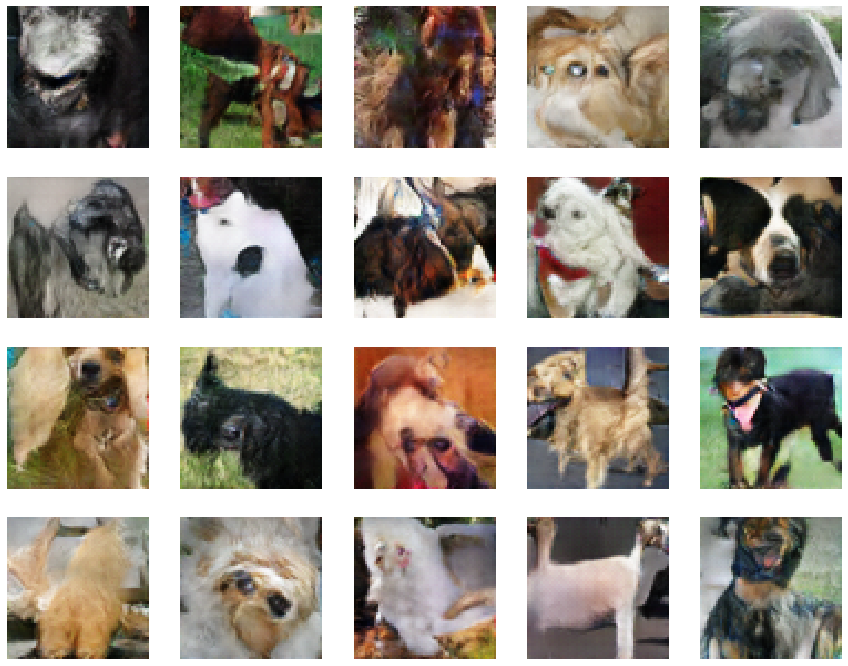

In [26]:
_ = generate(generator, n=20, n_plot=20, latent_dim=latent_dim)

### Latent Walk

In [ ]:
for i in range(5):
    latent_walk(generator, n=5, latent_dim=latent_dim)

In [ ]:
print(f"Done in {(time.time() - begin)/60:.1f} minutes")